# Signal to noise calculations for the Huntsman Telephoto Array

This notebook contains signal to noise calculations for the Huntsman Telephoto Array.

## Standard imports

In [1]:
import sys
sys.path.append('..')

In [2]:
%matplotlib inline

In [34]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.colors as colours

## Import gunagala

`gungala` is the library that performs the SNR/sensitivity/ETC calculations. The main submodule is `imager` which includes the `Imager` class which represents an astronomical imaging instrument.

In [4]:
from gunagala import imager

/Users/ajh/anaconda/envs/POCS/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Create imagers

The `gunagala.imager.create_imagers()` creates a dictionary of `Imager` objects based on the `gunagala/data/performance.yaml` configuration file as well as performance data files in `gunagala/data/performance_data`. The instrument configuration/specifications should be set by editing these files.

Currently the file describes 2 variants of the Australian Space Eye concept and a 5 lens version of the Huntsman Telephoto Array.

In [5]:
imagers = imager.create_imagers()
huntsman = imagers['canon_sbig']  # A 5 lens array
waves_h = huntsman.wavelengths

## Inspect imager properties

Many properties of the imagers can be accessed as properties of the `Imager` object.

### Field of view

In [28]:
huntsman.pixel_scale

<Quantity 2.8486699583997965 arcsec / pix>

In [30]:
huntsman.field_of_view

<Quantity [ 2.63185452, 1.98140822] deg>

In [31]:
huntsman.camera.resolution

<Quantity [ 3326., 2504.] pix>

### Filter profiles 

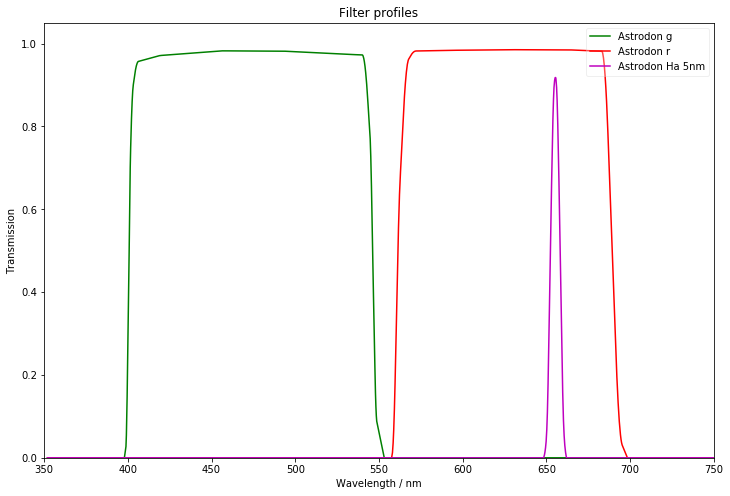

In [6]:
plt.plot(waves_h, huntsman.filters['g'].transmission(waves_h), 'g-', label='Astrodon g')
plt.plot(waves_h, huntsman.filters['r'].transmission(waves_h), 'r-', label='Astrodon r')
plt.plot(waves_h, huntsman.filters['Ha_5nm'].transmission(waves_h), 'm-', label='Astrodon Ha 5nm')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlabel('Wavelength / nm')
plt.ylabel('Transmission')
plt.title('Filter profiles')
plt.xlim(350, 750)
plt.ylim(0, 1.05)
plt.gcf().set_size_inches(12,8)

In [7]:
huntsman.filters['g'].FWHM

<Quantity 145.51289296863763 nm>

In [8]:
huntsman.filters['g'].lambda_c

<Quantity 473.48435842079374 nm>

In [9]:
huntsman.filters['r'].FWHM

<Quantity 128.0992731859991 nm>

In [10]:
huntsman.filters['r'].lambda_c

<Quantity 625.3154651758034 nm>

### Image sensor quantum efficiency

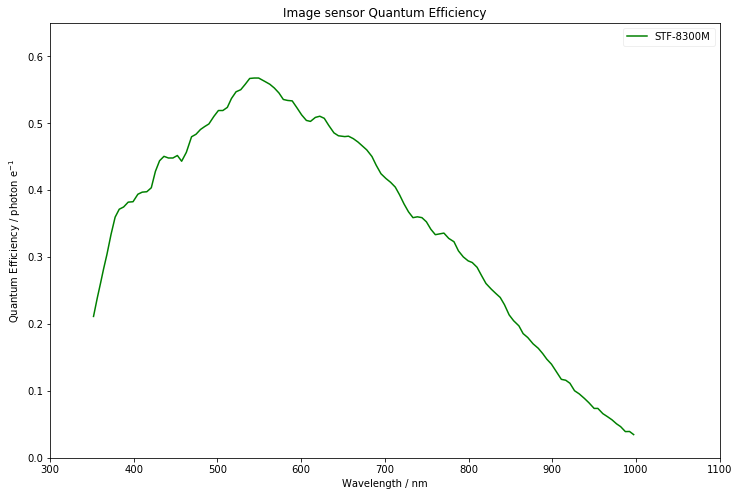

In [11]:
plt.plot(huntsman.camera.wavelengths, huntsman.camera.QE, 'g-', label='STF-8300M')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlabel('Wavelength / nm')
plt.ylabel('Quantum Efficiency / photon e$^{-1}$')
plt.title('Image sensor Quantum Efficiency')
plt.xlim(300, 1100)
plt.ylim(0,0.65)
plt.gcf().set_size_inches(12,8)

### End to end efficiency

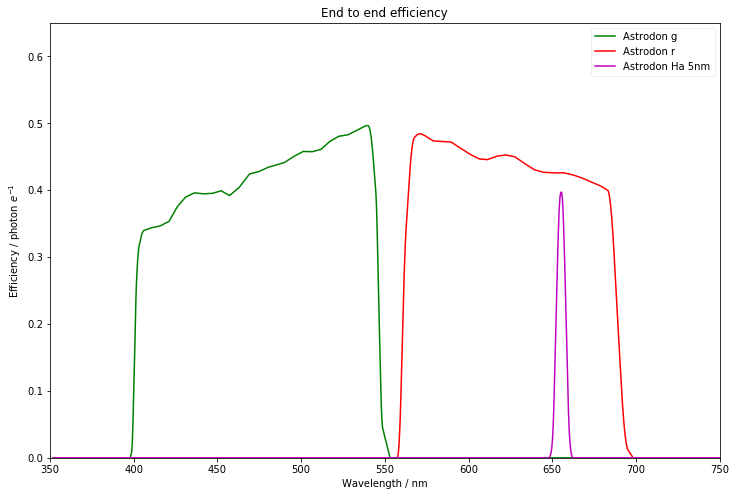

In [12]:
plt.plot(waves_h, huntsman.efficiencies['g'], 'g-', label='Astrodon g')
plt.plot(waves_h, huntsman.efficiencies['r'], 'r-', label='Astrodon r')
plt.plot(waves_h, huntsman.efficiencies['Ha_5nm'], 'm-', label='Astrodon Ha 5nm')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlabel('Wavelength / nm')
plt.ylabel('Efficiency / photon $e^{-1}$')
plt.title('End to end efficiency')
plt.xlim(350, 750)
plt.ylim(0, 0.65)
plt.gcf().set_size_inches(12,8)

### PSF model

In [17]:
huntsman.psf.FWHM

<Quantity 2.0 arcsec>

In [18]:
huntsman.psf.shape

Parameter('alpha', value=4.5)

In [20]:
huntsman.psf.peak

<Quantity 0.7074749860595911 1 / pix>

In [21]:
huntsman.psf.n_pix

<Quantity 4.281916434594633 pix>

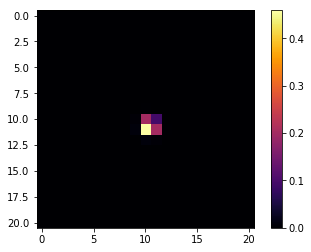

In [38]:
plt.imshow(huntsman.psf.pixellated(offsets=(0.33, 0.67)), interpolation='none', cmap='inferno')
plt.colorbar()

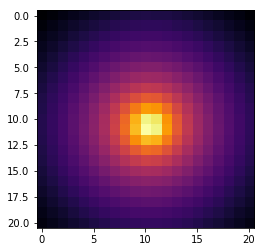

In [39]:
plt.imshow(huntsman.psf.pixellated(offsets=(0.33, 0.67)), interpolation='none', cmap='inferno', norm=colours.LogNorm())

### Sky background model

For Huntsman we use the `Simple` sky model from `gunagala`, which has a single pre-defined sky brightness value (in AB magnitudes per square arcsecond) for each filter bandpass. For the time being the values are taken from the predicted g' and r' band sky brightnesses for CTIO given at http://www.ctio.noao.edu/noao/node/1218. These are dark time (no Moon) values for zenith.

In [13]:
huntsman.sky.surface_brightness('g')

<Magnitude 22.3 mag(AB)>

In [14]:
huntsman.sky.surface_brightness('r')

<Magnitude 21.4 mag(AB)>

In [15]:
huntsman.sky.surface_brightness('Ha_5nm')

<Magnitude 21.4 mag(AB)>

### Detected sky background levels

Pre-calculated for each filter. Also dark current for comparison.

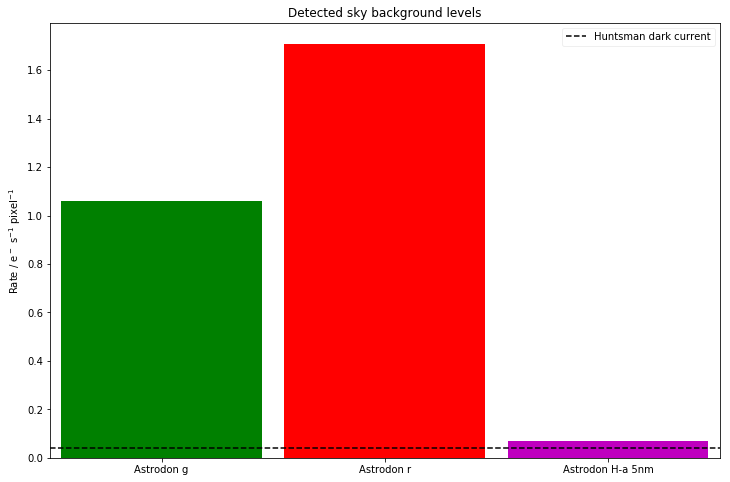

In [16]:
plt.bar((1, 2, 3), (huntsman.sky_rate['g'].value, huntsman.sky_rate['r'].value, huntsman.sky_rate['Ha_5nm'].value),
        width=0.9, align='center', color=('g', 'r', 'm'))
plt.hlines(huntsman.camera.dark_current.value, 0.5, 3.5, linestyle='dashed', label='Huntsman dark current')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)

plt.xticks((1, 2, 3), 
           ('Astrodon g', 'Astrodon r', 'Astrodon H-a 5nm'))
plt.xlim(0.5,3.5)
plt.ylabel('Rate / e$^-$ s$^{-1}$ pixel$^{-1}$')
plt.title('Detected sky background levels')
plt.gcf().set_size_inches(12, 8)

## Point source sensitivity

### Single 1 minute exposure

In [41]:
huntsman.point_source_limit(total_exp_time=1*u.minute,
                            filter_name='g',
                            snr_target=5.0,
                            sub_exp_time=60*u.second)

<Magnitude 20.0958387071198 mag(AB)>

In [42]:
huntsman.point_source_saturation_mag(sub_exp_time=60*u.second, filter_name='g')

<Magnitude 13.241073514330537 mag(AB)>

### Single exposures from 1 to 10 minutes

In [58]:
ts = np.arange(1,10.1,0.25) * u.minute

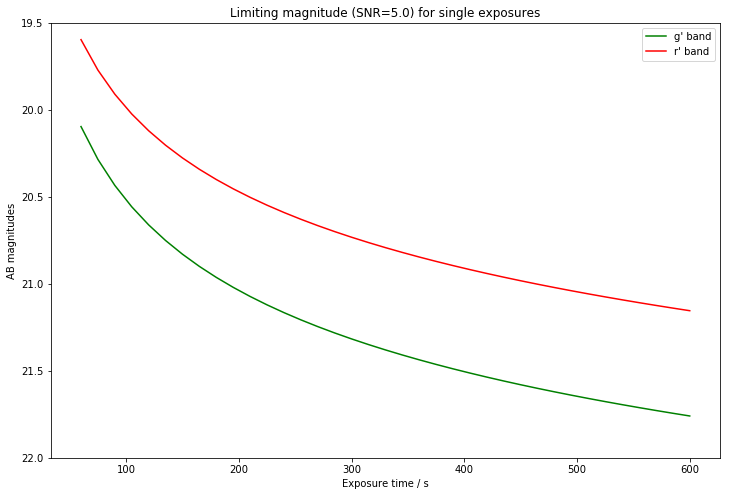

In [59]:
plt.plot(ts.to(u.second), huntsman.point_source_limit(total_exp_time=ts, sub_exp_time=ts,
                                                      filter_name='g', snr_target=5.0), 'g-', label="g' band")
plt.plot(ts.to(u.second), huntsman.point_source_limit(total_exp_time=ts, sub_exp_time=ts,
                                                      filter_name='r', snr_target=5.0), 'r-', label="r' band")
plt.ylim(22, 19.5)
plt.legend()
plt.title("Limiting magnitude (SNR=5.0) for single exposures")
plt.xlabel("Exposure time / s")
plt.ylabel("AB magnitudes")
plt.gcf().set_size_inches(12, 8)

### For 1% photometry with single exposures

Require a signal to noise of at least 100. Will also calculate the saturation limit.

In [74]:
g_100 = huntsman.point_source_limit(total_exp_time=ts, sub_exp_time=ts, filter_name='g', snr_target=100.0)
g_sat = huntsman.point_source_saturation_mag(sub_exp_time=ts, filter_name='g')
r_100 = huntsman.point_source_limit(total_exp_time=ts, sub_exp_time=ts, filter_name='r', snr_target=100.0)
r_sat = huntsman.point_source_saturation_mag(sub_exp_time=ts, filter_name='r')

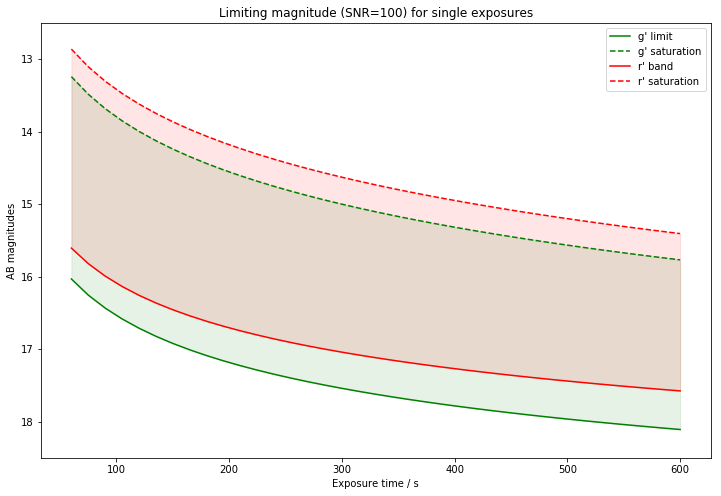

In [83]:
plt.plot(ts.to(u.second), g_100, 'g-', label="g' limit")
plt.plot(ts.to(u.second), g_sat, 'g--', label="g' saturation")
plt.fill_between(ts.to(u.second).value, g_100.value, g_sat.value, color='g', alpha=0.1)

plt.plot(ts.to(u.second), r_100, 'r-', label="r' band")
plt.plot(ts.to(u.second), r_sat, 'r--', label="r' saturation")
plt.fill_between(ts.to(u.second).value, r_100.value, r_sat.value, color='r', alpha=0.1)

plt.ylim(18.5,12.5)
plt.legend()
plt.title("Limiting magnitude (SNR=100) for single exposures")
plt.xlabel("Exposure time / s")
plt.ylabel("AB magnitudes")
plt.gcf().set_size_inches(12, 8)